In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import numpy as np
from scipy.stats import norm
from dataclasses import dataclass

from utils import *
from config import *

from tqdm import tqdm


## How does this work?

This notebook executes a power analysis when the goal is to run discovery / elasticities tests for customer areas. Test setup is based on what was shared in the [Pricing Community VII](https://docs.google.com/presentation/d/17DcFaQTIVhFMLIZcWUR7lKg6VU-bidehiqQxXSUGJxQ/edit) regarding customer location. Since the analysis is not at the city level but rather at areas, we need to ensure that all areas must meet the sample size. 

The methodology here proposes an algorithm that takes area shapes, some session data and outputs a smaller, consolidated list of areas that should be analyzed together. The algorithm works assuming that if the smallest area, defined by the number of users making sessions, meets the sample size, all bigger areas will too. If an area does not meet the sample size, it must be merged with another area. The step-by-step process is the following:

- Load required data from BQ -> area shapes + session, conversion data at the user level + area indicator
- Initialize the tests parameters (n_variants, mde, alpha, power) plus a area mapping
    - The area mapping is extremely important. It keeps a log of which area should be merged with another one. For example, at iteration 0 we got the following mapping {"A":"A", "B":"B", "C":"C"}.\
      In the first iteration, it was decided that area "C" should be added to "A". thus, the new mapping is: {"A":"A", "B":"B", "C":"A"}.
- aggregate user level data to find the smallest area
- Using the aggregated data, find the smallest neighbor for each area.
- Calculate the required sample size for the intented MDE and compare it to the number of users in the area.
  - if the area has more user. Amazing, algorithm will stop. 
  - otherwise, merge the area to their smallest neighbor.
    - In the case the area doesn't have any neighbor, it will be merged with the next overall smallest area.
- Update the area mappings

Repeat until the algorithm has managed to find all areas that meet the sample size or it has exhausted all iterations.




### TO-DO
- ~~Parametrize sql arguments to allow different inputs~~ 
- Wrap the while in a function or what? 
- Persist aggregated shapes (BQ table, csv?)
- Remove non-exis

# Code

## Load data

In [3]:
connector = Connector(**BIGQUERY_CONFIG)

In [4]:
athens_inputs = {
    "shape_query" : QueryArgs(
        filename = "area-shapes.sql",
        params = {
            "country_code":"gr",
            "city":"Attica"
        }
    )

    , "session_query" : QueryArgs(
        filename = "cvr-per-area.sql",
        params = {
            "country_code":"gr",
            "city":"Attica",
            "entity_id":"EF_GR",
            "weeks_ago":4,
            "city_id":1,
            "asa_ids":[79]
        }
    )

    , "city_query" : QueryArgs(
        filename = "city-dh-shape.sql",
        params = {
            "entity_id":"EF_GR",
            "city_id":1
        }
    )
}


In [5]:
session_data = connector.get_df_from_query(QueryHandler.build_query(athens_inputs["session_query"]))


# why i'm loading two shapes dataset? Can't I just bring the intersects of this two?
area_shapes = (
    connector
    .get_df_from_query(QueryHandler.build_query(athens_inputs["shape_query"]))
    .pipe(convert_to_geopandas, "area_shape")
    .drop(columns=["area_shape"])
)

city_dh_shape = (
    connector
    .get_df_from_query(QueryHandler.build_query(athens_inputs["city_query"]))
    .pipe(convert_to_geopandas, "city_shape")
    .drop(columns=["city_shape"])
)


Job ID 8011e718-3d73-42d1-8015-49ab0e401251 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
Job ID 49a238f5-e45d-4fe4-b1ba-ddad6d6bccd2 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
Job ID dfc80c29-706d-48fa-8b0f-8e68de486b90 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


# Multiple Power Analysis

- Goal is to see how many areas we can have at different MDE levels

- How to run in parallel?

In [7]:
aggregate_user_data_per_area(session_data, "area_name")

,area_name,avg_sessions,avg_conversions,total_session,total_conversion,n_users
27,Kropia,2.877551,0.0,141,0,49
16,Fyli,2.4,0.018182,132,1,55
12,Dionysos,2.562075,0.000425,6026,1,2352
34,Paiania,2.355054,0.000835,5638,2,2394
2,Agia Varvara,3.067949,0.048182,17383,273,5666
43,Vrilissia,2.806226,0.007823,17219,48,6136
28,Lykovrysi-Pefki,2.745358,0.003552,17002,22,6193
37,Papagou-Cholargos,2.650215,0.160219,17881,1081,6747
38,Penteli,2.758705,0.001295,19173,9,6950
15,Filothei-Psychiko,2.738479,0.431433,19550,3080,7139


In [8]:
import itertools
import joblib

mde_levels = [0.1, 0.25, 0.5, 0.75, 1]
n_variants = [5]
pop_shares = [0.2, 0.4, 0.5, 0.6, 0.8, 1.0]


it_df = (
    session_data
    .copy()
)

# 
it_shapes = (
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
)

permutations = list(itertools.product(mde_levels, n_variants, pop_shares))
permutations_dict = [{"it_df":it_df, "it_shapes":it_shapes, "power_params":PowerParams(mde=x[0]/100, n_variants=x[1]), "pop_share":x[2]} for x in permutations]

# permutations_dict[0]
results = joblib.Parallel(n_jobs=3)(joblib.delayed(run_power_analysis_per_area)(**params) for params in tqdm(permutations_dict))
# for perm in tqdm(permutations):
#     # print(perm)
#     results = joblib.Parallel(n_jobs=2)(joblib.delayed(run_power_analysis_per_area
#         it_df
#         , it_shapes 
#         , power_params=PowerParams(mde= perm[1]/100, n_variants=perm[0])
#         , pop_share=perm[2]
#     )


#     mapping_results.append(
#         {
#             "mde":perm[1]/100,
#             "n_variants":perm[0],
#             "pop_share":perm[2],
#             "is_feasible": is_feasible,
#             "n_areas": len(set(area_mapping.values())),
#             "mapping":area_mapping,
#             # "mapping_logs":
#         }
#     )



    



 40%|████      | 12/30 [01:20<02:53,  9.64s/it]/Users/s.lafaurie/anaconda3/envs/pygeo/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 30/30 [04:48<00:00,  9.63s/it]


In [10]:
results

[MappingResults(final_mapping={}, is_feasible=False, mapping_logs=[], power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=5), pop_share=0.2),
 MappingResults(final_mapping={}, is_feasible=False, mapping_logs=[], power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=5), pop_share=0.4),
 MappingResults(final_mapping={}, is_feasible=False, mapping_logs=[], power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=5), pop_share=0.5),
 MappingResults(final_mapping={}, is_feasible=False, mapping_logs=[], power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=5), pop_share=0.6),
 MappingResults(final_mapping={}, is_feasible=False, mapping_logs=[], power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=5), pop_share=0.8),
 MappingResults(final_mapping={}, is_feasible=False, mapping_logs=[], power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=5), pop_share=1.0),
 None,
 MappingResults(final_mapping={'K

In [11]:
[
    {
        "mde":x.power_params.mde*100,
        "n_variants":x.power_params.n_variants,
        "pop_share":x.pop_share,
        "n_areas": len(set(x.final_mapping.values())),
    }
    for x in results if x is not None and x.is_feasible
]

[{'mde': 0.25, 'n_variants': 5, 'pop_share': 0.4, 'n_areas': 17},
 {'mde': 0.25, 'n_variants': 5, 'pop_share': 0.5, 'n_areas': 17},
 {'mde': 0.25, 'n_variants': 5, 'pop_share': 0.6, 'n_areas': 20},
 {'mde': 0.25, 'n_variants': 5, 'pop_share': 0.8, 'n_areas': 22},
 {'mde': 0.25, 'n_variants': 5, 'pop_share': 1.0, 'n_areas': 23},
 {'mde': 0.5, 'n_variants': 5, 'pop_share': 0.2, 'n_areas': 22},
 {'mde': 0.5, 'n_variants': 5, 'pop_share': 0.4, 'n_areas': 26},
 {'mde': 0.5, 'n_variants': 5, 'pop_share': 0.5, 'n_areas': 28},
 {'mde': 0.5, 'n_variants': 5, 'pop_share': 0.6, 'n_areas': 30},
 {'mde': 0.5, 'n_variants': 5, 'pop_share': 0.8, 'n_areas': 28},
 {'mde': 0.5, 'n_variants': 5, 'pop_share': 1.0, 'n_areas': 33},
 {'mde': 0.75, 'n_variants': 5, 'pop_share': 0.2, 'n_areas': 28},
 {'mde': 0.75, 'n_variants': 5, 'pop_share': 0.4, 'n_areas': 33},
 {'mde': 0.75, 'n_variants': 5, 'pop_share': 0.5, 'n_areas': 33},
 {'mde': 0.75, 'n_variants': 5, 'pop_share': 0.6, 'n_areas': 35},
 {'mde': 0.75, '

In [13]:
(
    pd.DataFrame([{
        "mde":x.power_params.mde*100,
        "n_variants":x.power_params.n_variants,
        "pop_share":x.pop_share,
        "n_areas": len(set(x.final_mapping.values())),
    }
    for x in results if x is not None and x.is_feasible
    ])
    # .query("is_feasible")
    # .drop(columns=["mapping"])
    # .to_csv("istanbul-power-levels.csv", index=False)
)

,mde,n_variants,pop_share,n_areas
0,0.25,5,0.4,17
1,0.25,5,0.5,17
2,0.25,5,0.6,20
3,0.25,5,0.8,22
4,0.25,5,1.0,23
5,0.50,5,0.2,22
6,0.50,5,0.4,26
7,0.50,5,0.5,28
8,0.50,5,0.6,30
9,0.50,5,0.8,28


# EDA results for chosen option

In [15]:
istanbul_power_params = PowerParams(mde=0.25/100, n_variants=5)
pop_share = 0.4

it_df = (
    session_data
    .copy()
)

# 
it_shapes = (
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
)

mapping_results = run_power_analysis_per_area(
    it_df
    , it_shapes 
    , power_params=istanbul_power_params
    , pop_share=pop_share
    , verbose=False
    , show_charts=False
    , use_progress_bar=True
)

 63%|██████▎   | 29/46 [01:40<00:58,  3.47s/it]


In [17]:
mapping_df = (
            it_df
            .assign(
                area_map = lambda df: df.area_name.map(mapping_results.final_mapping)
        )  
        .groupby( ["area_map"], as_index=False)
        .agg(
                avg_sessions = ("n_sessions", "mean")
                ,  avg_conversions = ("n_conversions", "mean")
                ,  total_session = ("n_sessions", "sum")
                ,  total_conversion = ("n_conversions", "sum")
                ,  n_users = ("perseus_client_id", "count")
                , areas = ("area_name", set)
        )        
        .assign(
                cvr=lambda df: df.total_conversion.div(df.total_session)
                , n_areas = lambda df: df.areas.apply(len)
        )
)


mapping_shapes = (
        it_shapes
        .pipe(aggregate_shape_data_per_area, mapping_results.final_mapping, "area_map")
        .merge(mapping_df, left_on="area_map", right_on="area_map")
        .drop(columns=["city", "country_code", "area_name"])
        )


mapping_shapes.sort_values(by="n_users")


,area_map,geometry,avg_sessions,avg_conversions,total_session,total_conversion,n_users,areas,cvr,n_areas
2,Dionysos,"POLYGON ((23.82233 38.11383, 23.82263 38.11391...",2.562075,0.000425,6026,1,2352,{Dionysos},0.000166,1
9,Lykovrysi-Pefki,"POLYGON ((23.80037 38.06570, 23.79901 38.06609...",2.745358,0.003552,17002,22,6193,{Lykovrysi-Pefki},0.001294,1
10,Metamorfosi,"POLYGON ((23.74515 38.05148, 23.74640 38.04979...",2.874969,0.006141,23408,50,8142,{Metamorfosi},0.002136,1
16,Vari-Voula-Vouliagmeni,"MULTIPOLYGON (((23.76736 37.77653, 23.76708 37...",2.824324,0.001126,30096,12,10656,{Vari-Voula-Vouliagmeni},0.000399,1
13,Pallini,"POLYGON ((23.84320 38.00814, 23.84366 38.00803...",2.640248,0.000729,28982,8,10977,{Pallini},0.000276,1
3,Elliniko-Argyroupoli,"POLYGON ((23.71708 37.89847, 23.71681 37.89847...",3.044469,0.009928,36491,119,11986,{Elliniko-Argyroupoli},0.003261,1
14,Penteli,"POLYGON ((23.85158 38.04539, 23.85124 38.04502...",2.780987,0.004356,36392,57,13086,"{Penteli, Vrilissia}",0.001566,2
8,Korydallos,"POLYGON ((23.63945 37.99590, 23.63676 37.99521...",3.077361,0.007946,41052,106,13340,{Korydallos},0.002582,1
0,Acharnes,"POLYGON ((23.73689 38.04865, 23.73842 38.04997...",2.782237,0.003388,37780,46,13579,{Acharnes},0.001218,1
6,Keratsini-Drapetsona,"MULTIPOLYGON (((23.62986 37.93930, 23.62930 37...",2.994235,0.000438,41030,6,13703,{Keratsini-Drapetsona},0.000146,1


Text(0.5, 1.0, 'Original')

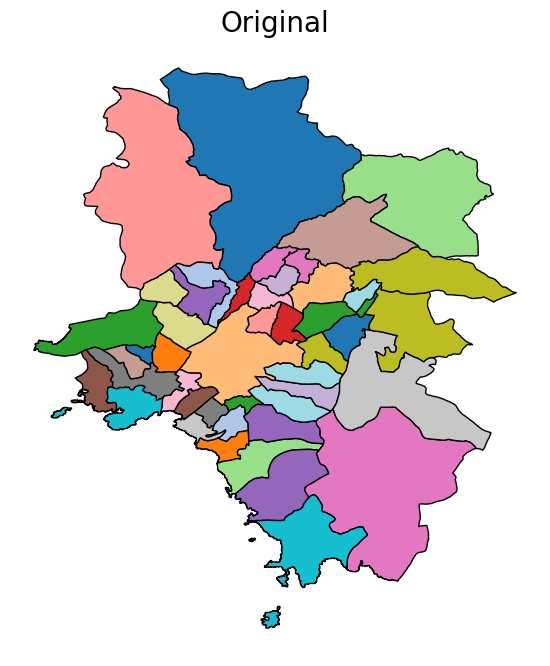

In [18]:
#Original shapes
it_shapes = (
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
)

ax = (
        it_shapes
        .pipe(aggregate_shape_data_per_area, mapping_results.mapping_logs[0], "area_map")
        # .merge(mapping_df, left_on="area_map", right_on="area_map")
        # .drop(columns=["city", "country_code", "area_name"])
        .plot(column="area_map", figsize=(15,8), legend=False, edgecolor="black", cmap="tab20")        
    )
ax.set_axis_off()
ax.set_title("Original", size=20)

In [19]:
# (
#     mapping_shapes
#     [["areas", "n_users", "avg_sessions", "cvr"]]
#     .assign(
#         areas = lambda df: df["areas"].apply(list).apply(", ".join)
#     )
#     # .rename={"areas":"Aras"}
#     .to_csv("data/istanbul-areas-data.csv", index=False)
#     # .style
#     # .format(precision=3)

# )

Text(0.5, 1.0, 'Merged')

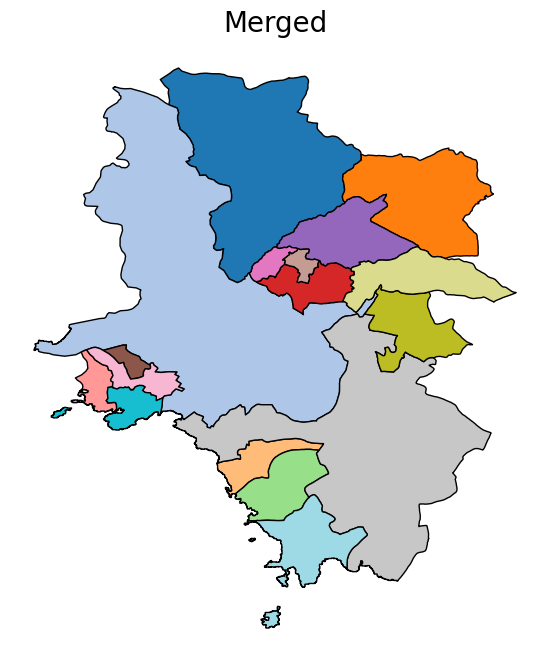

In [20]:
#Final Shape shapes
ax = mapping_shapes.plot(column="area_map", figsize=(15,8), legend=False, edgecolor="black", cmap="tab20")
ax.set_axis_off()
ax.set_title("Merged", size=20)